In [ ]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import vae # file where the architecture etc. of the autoencoder is defined
import warnings

from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
# search for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Traning on", device)

Traning on cpu


In [ ]:
# definition of hyperparameters
batch_size = 16

hidden_dim = 300
latent_dim = 50

lr = 1e-5

epochs = 500

train_size = 0.9

In [ ]:
# preprocessing of the images (already extracted from pdf->old data format)
warnings.filterwarnings('ignore')

# Try to load already preprocessed pictures or start new preprocessing
try:
    with open('../../resource/vae/images_tensor_255_200x200.pkl', 'rb') as f:
    img_list = pickle.load(f)
    
except FileNotFoundError:
    
    # List of image formats that can be used
    allowed = ["png", "PNG", "jpg", "JPG", "jpeg", "JPEG", "eps", "EPS"]
    img_list = []
    load_counter = 0
    error_counter = 0
    counter = 0

    directory = [str(i) for i in list(Path("./datapics/").rglob("*.*")) if str(i).split(".")[-1] in allowed]

    for img_path in tqdm(directory):
        counter += 1
        try:
            
            # open image, convert to RGBA and resize to 200x200
            image = Image.open(img_path).convert(mode="RGBA").resize((200,200))

            img_list.append(image)

            load_counter += 1

            del image

        except:

            error_counter += 1

    print(str(error_counter) + " images throw an error while loading")
    print(str(load_counter) + " images load successfully")

    # safe the results
    with open('../../resource/vae/images_tensor_255_200x200.pkl', 'wb') as f:
        pickle.dump(img_list, f)

In [ ]:
# split the images into train and test
data_train = img_list[:round(len(img_list)*train_size)]
data_test = img_list[round(len(img_list)*train_size):]
del img_list

In [ ]:
# transform the images to tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5, 0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5, 0.5])])

train_dataset = vae.MyDataset(data_train, transform=transform)
test_dataset = vae.MyDataset(data_test, transform=transform)

In [ ]:
# create dataloaders to feed data into the neural network
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


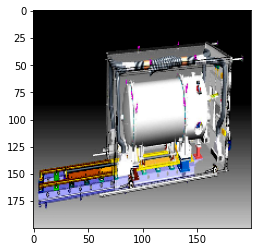

In [ ]:
# test visualization of one image
batch_idx, data = next(enumerate(train_loader))
plt.imshow(data[9].detach().cpu().view(-1,4, 200,200)[0].permute(1,2,0))

In [ ]:
# initialization of the models
vae.encoder = Encoder(hidden_dim=hidden_dim, latent_dim=latent_dim)
vae.decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim)

vae.model = VAE(Encoder=encoder, Decoder=decoder).to(device)

In [ ]:
#loss function: mse and kld
from torch.optim import Adam

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x, x_hat, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    loss = reproduction_loss + KLD

    return loss, reproduction_loss, KLD

In [ ]:
optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
#try to load older training status
try:

    open_file = open("../../resource/vae/training_test_history.pkl", "rb")
    training_test_history = pickle.load(open_file)
    open_file.close()

    restored_epoch = max(training_test_history['test_loss']['loss'].keys())
    model.load_state_dict(torch.load(f"../../resource/vae/models/VAE_epoch_{restored_epoch}.pt", map_location=device))

    print(f"Loaded older training status from epoch {restored_epoch}")

except (FileNotFoundError, ValueError):

    training_test_history = {'training_loss': {"loss": {}, "reproduction_loss": {}, "KLD": {}}, 'test_loss': {"loss": {}, "reproduction_loss": {}, "KLD": {}}}

    restored_epoch = 0

    print("Starting Training from scratch.")

Loaded older training status from epoch 168


In [ ]:
# training loop with continous testing
print("Start training VAE...")
print("-"*30)

model.train()

for epoch in range(restored_epoch+1, epochs+1):
    
    # reset loss to start with new epoch
    overall_loss = 0
    overall_reproduction_loss = 0
    overall_KLD = 0

    # iterate over batches
    for batch_idx, data in enumerate(train_loader):
        
        x = data.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var, z = model(x)
        loss, reproduction_loss, KLD = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        overall_reproduction_loss += reproduction_loss.item()
        overall_KLD += KLD.item()
        
        loss.backward()
        optimizer.step()

        del data
        del x
        del x_hat
    
    # safe the training loss values of the epoch
    training_test_history['training_loss']['loss'][epoch] = overall_loss / (batch_idx*batch_size)
    training_test_history['training_loss']['reproduction_loss'][epoch] = overall_reproduction_loss / (batch_idx*batch_size)
    training_test_history['training_loss']['KLD'][epoch] = overall_KLD / (batch_idx*batch_size)

    # start continous testing
    model.eval()

    with torch.no_grad():
        
        # reset loss to start with testing new epoch
        overall_test_loss = 0
        overall_test_reproduction_loss = 0
        overall_test_KLD = 0
        
        # iterate over test batches
        for batch_idx, data in enumerate(test_loader):

            x = data.to(device)

            x_hat, mean, log_var, z = model(x)
            test_loss, test_reproduction_loss, test_KLD = loss_function(x, x_hat, mean, log_var)

            overall_test_loss += test_loss.item()
            overall_test_reproduction_loss += test_reproduction_loss.item()
            overall_test_KLD += test_KLD.item()

            del data
            del x
            del x_hat
    
    # safe the test loss values of the epoch
    training_test_history['test_loss']['loss'][epoch] = overall_test_loss / (batch_idx*batch_size)
    training_test_history['test_loss']['reproduction_loss'][epoch] = overall_test_reproduction_loss / (batch_idx*batch_size)
    training_test_history['test_loss']['KLD'][epoch] = overall_test_KLD / (batch_idx*batch_size)
    
    # end the testing mode
    model.train()

    # save every model and training history
    torch.save(model.state_dict(),f'../../resource/vae/models/VAE_epoch_{epoch}.pt')

    open_file = open(f"../../resource/vae/training_test_history.pkl", "wb")
    pickle.dump(training_test_history, open_file)
    open_file.close()

    print(f"\tEpoch {epoch} complete! \tAverage Train Loss:  {training_test_history['training_loss']['loss'][epoch]} (Best Epoch: {min(training_test_history['training_loss']['loss'], key=training_test_history['training_loss']['loss'].get)}) \t\tAverage Test Loss: {training_test_history['test_loss']['loss'][epoch]} (Best Epoch: {min(training_test_history['test_loss']['loss'], key=training_test_history['test_loss']['loss'].get)})")
    print("-"*30)

    
print("Finish!")

Start training VAE...
------------------------------
	Epoch 169 complete! 	Average Train Loss:  6185.339495051807 (Best Epoch: 168) 		Average Test Loss: 17390.551610854065 (Best Epoch: 169)
------------------------------
	Epoch 170 complete! 	Average Train Loss:  6003.402674546277 (Best Epoch: 168) 		Average Test Loss: 17357.255323687805 (Best Epoch: 170)
------------------------------
	Epoch 171 complete! 	Average Train Loss:  5849.244624236185 (Best Epoch: 168) 		Average Test Loss: 17343.425814434162 (Best Epoch: 171)
------------------------------
	Epoch 172 complete! 	Average Train Loss:  5722.73171825186 (Best Epoch: 168) 		Average Test Loss: 17302.191339881676 (Best Epoch: 172)
------------------------------
	Epoch 173 complete! 	Average Train Loss:  5610.078704088071 (Best Epoch: 168) 		Average Test Loss: 17308.424126782462 (Best Epoch: 172)
------------------------------
	Epoch 174 complete! 	Average Train Loss:  5507.956768429115 (Best Epoch: 174) 		Average Test Loss: 17317.95

### Test by generating a new image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


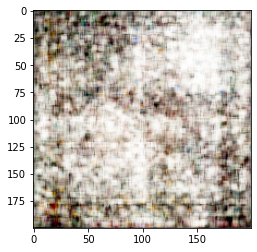

In [ ]:
# sample random images from latent space
with torch.no_grad():
    noise = torch.randn(1, latent_dim).to(device)
    generated_images = decoder(noise)

plt.imshow(generated_images[0].detach().cpu().view(-1,4, 200,200)[0].permute(1,2,0))

### Apply Model on real image and return z-Vector

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


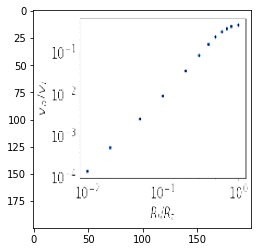

In [ ]:
pic = 2 # index of the image in the badge to use
batch_idx, data = next(enumerate(train_loader))

# the original image
plt.imshow(data[pic].detach().cpu().view(-1,4, 200,200)[0].permute(1,2,0))

In [ ]:
with torch.no_grad():
    x_hat, mean, log_var, z = model(data.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


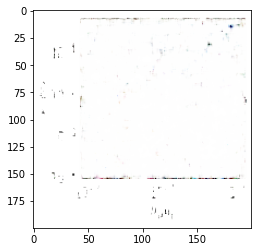

In [ ]:
# the rebuild image
plt.imshow(x_hat[pic].detach().cpu().view(-1,4, 200,200)[0].permute(1,2,0))

In [ ]:
# latent space of the image
z.cpu().numpy()[pic]

array([-4.5507483 , -3.0416992 ,  4.0654187 , -2.020963  ,  0.16486028,
       -0.79879105, -1.628782  ,  0.67428845, -1.4120028 , -2.99027   ,
        4.0231504 , -4.087657  ,  0.95467013,  4.1723504 ,  4.520218  ,
        9.517388  , -0.6134985 ,  3.087195  , -6.8014684 ,  4.7102923 ,
       -1.4385935 , -0.4505856 ,  3.0292003 , -1.129715  ,  3.8919175 ,
       -0.33716303,  5.666009  , -1.3099853 , -2.3741784 , -9.630381  ,
        1.0036461 ,  2.032445  , -0.9482028 , -0.5422133 ,  4.004899  ,
        0.39930788, -3.3874722 ,  1.3372513 ,  1.5968925 , -3.8814554 ,
       -2.3786404 , -5.396738  ,  0.82451075, -1.3029698 , -1.9075431 ,
       -0.3785115 , -2.640731  ,  6.0144877 ,  7.739671  ,  0.32348424],
      dtype=float32)